In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import PROJECT.util as f
from matplotlib.pyplot import cm

In [291]:
# Pour des vecteurs u* et v*,
# les overlaps obtenus sont soit les deux positifs ou les deux négatifs, on a:
# overlap(u*)= -x et overlap(v*)= -y ou overlap(u*)= x et overlap(v*)= y.
# on prend donc le min(u-x, u+x):

# si u est positif et x est positif:
# min(u-x, u+x) -> u-x est bon

# si u est positif et x est négatif:
# min(u-(-x), u+(-x)) -> u+(-x) =u-x est bon

# si u est négatif et x est positif:
# min(-u-x, -u+x) -> -u+x =x-u est bon

# si u est négatif et x est négatif:
# min(-u-(-x), -u+(-x)) -> -u-(-x) =x-u est bon

def mse(x,y):
    a=torch.pow((x-y),2).mean(0)
    b=torch.pow((x+y),2).mean(0)
    return torch.min(a,b)

In [292]:
def main_gradient_2_sans_proj_normalisation(iteration, u_p, v_p, Y, u_, v_, N, M, lambda_, beta_u, beta_v, lambda_1, lambda_2, dt):

    res = []
    res_mse= []
    
    mod = iteration*0.1
    
    stabilisation_check=np.empty((0,2))

    for i in range(iteration):

        # Computation
        sqrt_dt = torch.sqrt(dt)

        u_1 = (1/lambda_1) * f.gradient_u_2(N, M, u_p,v_p,Y,lambda_) * dt
        u_2 = torch.sqrt(2/(lambda_1*beta_u)) * torch.empty(N).normal_(mean=0,std=sqrt_dt)
        u_3 = ((N-1)/(N*lambda_1*beta_u))*u_p*dt
        u_n = u_p - u_1 + u_2 - u_3

        v_1 = 1/lambda_2 * f.gradient_v_2(N,M,u_p,v_p,Y,lambda_) * dt
        v_2 = torch.sqrt(2/(lambda_2*beta_v)) * torch.empty(M).normal_(mean=0,std=sqrt_dt)
        v_3 = ((M-1)/(M*lambda_2*beta_v))*v_p*dt
        v_n = v_p - v_1 + v_2 - v_3

        # Normalisation
        u_n = u_n / torch.linalg.norm(u_n)
        v_n = v_n / torch.linalg.norm(v_n)
        u_n = u_n * torch.sqrt(N)
        v_n = v_n * torch.sqrt(M)

        # Re-asign for the loop
        u_p = u_n
        v_p = v_n
    
        res_u = torch.abs(f.overlap(u_,u_n,N))
        res_v = torch.abs(f.overlap(v_,v_n,M))
        res.append((res_u,res_v))
        
        res_mse.append((mse(u_,u_n), mse(v_,v_n)))
        
        if i%mod==0:
            print(f"progress {100*i/iteration:.2f}%", end="\r")
        if i==iteration-1:
            print(f"overlap(u, v): ({res_u}; {res_v})")

    return np.array(res), np.array(res_mse)

In [294]:
if len(stabilisation_check)==0:
            #print("INIT")
            stabilisation_check=np.append(stabilisation_check, [[res_u,res_v]], axis=0)
        elif len(stabilisation_check)==200:
            #print("FINISH")
            print(f"overlap(u, v): ({res_u}; {res_v})")
            return np.array(res), np.array(res_mse)
        elif (np.abs(stabilisation_check-[res_u,res_v])<0.01).all():
            #print("ADD")
            stabilisation_check=np.append(stabilisation_check, [[res_u,res_v]], axis=0)
        else:
            #print("RESET")
            stabilisation_check=np.empty((0,2))

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

In [295]:
def one_run(lambda_=2, N=200, M=200, beta_u=2, beta_v=2, lambda_1=1,
        lambda_2=0.1, dt=1/500, iteration=10000):
      #Size of the matrix Y
    N = torch.tensor(N)
    M = torch.tensor(M)

    # lambda
    lambda_ = torch.tensor(lambda_)

    #temperatures
    beta_u = torch.tensor(beta_u)
    beta_v = torch.tensor(beta_v)

    #learning rates
    lambda_1 = torch.tensor(lambda_1)
    lambda_2 = torch.tensor(lambda_2)

    # Pas de temps
    dt = torch.tensor(dt)

    u_ = f.generate_vector(N)
    v_ = f.generate_vector(M)

    Y = f.generate_Y(N, M, u_,v_, lambda_)
    #print(Y)

    # Conditions initiales
    u_p = f.generate_vector(N)
    v_p = f.generate_vector(M)

    # Perform the gradient descent
    (res, res_mse) = main_gradient_2_sans_proj_normalisation(iteration, u_p, v_p, Y, u_, v_, N, M, lambda_, beta_u, beta_v, lambda_1, lambda_2, dt)
    
    return res, res_mse


In [296]:
# MAIN METHOD:

def main(size_of_one_sample, list_value_1, list_value_2):
    
    all_overlap_iterations=[]
    all_final_overlaps=[]
    
    all_mse_iterations=[]
    all_final_mse=[]
    
    for value_to_test_1 in list_value_1:
        
        for value_to_test_2 in list_value_2:
        
            one_run_overlap_iterations=[]
            one_run_mse_iterations=[]

            # Calculation
            for _ in range(size_of_one_sample):
                (current_uv_overlap,current_uv_mse)=one_run(beta_u=value_to_test_1, beta_v=value_to_test_2)
                # Store the overlap at the end of each iterations:
                one_run_overlap_iterations.append(current_uv_overlap)
                # Store the mse at the end of each iterations:
                one_run_mse_iterations.append(current_uv_mse)

            # Store the overlap/mse at the final iteration:
            one_run_final_overlap = np.array([x[-1] for x in one_run_overlap_iterations])
            one_run_final_mse = np.array([x[-1] for x in one_run_mse_iterations])

            # Add the results of this specific run to the global array:
            # overlap at all iterations:
            all_overlap_iterations.append(one_run_overlap_iterations)
            # overlap at the final iteration:
            all_final_overlaps.append(one_run_final_overlap)
            # mse at all iterations:
            all_mse_iterations.append(one_run_mse_iterations)
            # mse at the final iteration:
            all_final_mse.append(one_run_final_mse)
            
    return np.array(all_overlap_iterations), np.array(all_final_overlaps), np.array(all_mse_iterations), np.array(all_final_mse)

In [297]:
print(np.logspace(-1,0.5, 10))

[0.1        0.14677993 0.21544347 0.31622777 0.46415888 0.68129207
 1.         1.46779927 2.15443469 3.16227766]


In [298]:
# MAIN CELL: DO THE COMPUTATION

list_value_1 = np.logspace(-1,0.5, 10)
#list_value_1 = np.arange(0.1, 1, 0.1)
#list_value_1 = np.array([1])

list_value_2 = np.logspace(-1,0.5, 10)
#list_value_2 = np.arange(0.1, 1, 0.1)
#list_value_2 = np.array([1])

size_of_one_sample=5

(overlap_at_each_iterations, overlap_at_final_iteration,
 mse_at_each_iterations, mse_at_final_iteration) = main(size_of_one_sample, list_value_1, list_value_2)

overlap(u, v): (0.07043032348155975; 0.1506987363100052)
overlap(u, v): (0.09585549682378769; 0.00906782504171133)
overlap(u, v): (0.09080834686756134; 0.020682472735643387)
overlap(u, v): (0.07882162928581238; 0.052442532032728195)
overlap(u, v): (0.07005827873945236; 0.04283145070075989)
overlap(u, v): (0.06863689422607422; 0.0452389270067215)
overlap(u, v): (0.019466951489448547; 0.01990528590977192)
overlap(u, v): (0.03595667704939842; 0.006629166658967733)
overlap(u, v): (0.04994795843958855; 0.03605790436267853)
overlap(u, v): (0.14545753598213196; 0.011902444064617157)
overlap(u, v): (0.21389560401439667; 0.13379424810409546)
overlap(u, v): (0.07414180785417557; 0.14386075735092163)
overlap(u, v): (0.03458719328045845; 0.03746556118130684)
overlap(u, v): (0.09396477043628693; 0.052656516432762146)
overlap(u, v): (0.07619550824165344; 0.11070942878723145)
overlap(u, v): (0.02590159885585308; 0.1027255430817604)
overlap(u, v): (0.11287491023540497; 0.05432599037885666)
overlap(u, 

overlap(u, v): (0.2600228786468506; 0.2569265067577362)
overlap(u, v): (0.15551595389842987; 0.17654405534267426)
overlap(u, v): (0.17377226054668427; 0.08514317870140076)
overlap(u, v): (0.07465095072984695; 0.09720053523778915)
overlap(u, v): (0.16812731325626373; 0.2336348295211792)
overlap(u, v): (0.13734498620033264; 0.18797603249549866)
overlap(u, v): (0.13393162190914154; 0.12435774505138397)
overlap(u, v): (0.04971044883131981; 0.056223321706056595)
overlap(u, v): (0.11066975444555283; 0.2799364924430847)
overlap(u, v): (0.04214974865317345; 0.00031202315585687757)
overlap(u, v): (0.017542066052556038; 0.034253932535648346)
overlap(u, v): (0.044692911207675934; 0.05880134180188179)
overlap(u, v): (0.0705006793141365; 0.010463354177772999)
overlap(u, v): (0.037406075745821; 0.12383285164833069)
overlap(u, v): (0.027707280591130257; 0.020024901255965233)
overlap(u, v): (0.01852243021130562; 0.09920240193605423)
overlap(u, v): (0.03939254581928253; 6.832599319750443e-05)
overlap(u

overlap(u, v): (0.41926124691963196; 0.5200952887535095)
overlap(u, v): (0.5047836899757385; 0.5413010120391846)
overlap(u, v): (0.46240973472595215; 0.5276490449905396)
overlap(u, v): (0.37085816264152527; 0.3876243531703949)
overlap(u, v): (0.34858211874961853; 0.42897799611091614)
overlap(u, v): (0.38367027044296265; 0.4159807562828064)
overlap(u, v): (0.47997012734413147; 0.5329431295394897)
overlap(u, v): (0.3717817962169647; 0.5316641330718994)
overlap(u, v): (0.39226463437080383; 0.43688833713531494)
overlap(u, v): (0.43722087144851685; 0.46360549330711365)
overlap(u, v): (0.47027358412742615; 0.5733911395072937)
overlap(u, v): (0.43511950969696045; 0.4953017830848694)
overlap(u, v): (0.5209375619888306; 0.6097167134284973)
overlap(u, v): (0.380644828081131; 0.38782379031181335)
overlap(u, v): (0.48618292808532715; 0.6153784394264221)
overlap(u, v): (0.40300697088241577; 0.45193251967430115)
overlap(u, v): (0.5579603910446167; 0.643381655216217)
overlap(u, v): (0.013519990257918

overlap(u, v): (0.5759555697441101; 0.6102340221405029)
overlap(u, v): (0.6764384508132935; 0.6572389006614685)
overlap(u, v): (0.6576197743415833; 0.6368086934089661)
overlap(u, v): (0.5772251486778259; 0.5950313806533813)
overlap(u, v): (0.6459236145019531; 0.6471360921859741)
overlap(u, v): (0.6498439311981201; 0.6490620970726013)
overlap(u, v): (0.6940041184425354; 0.7455033659934998)
overlap(u, v): (0.6657862663269043; 0.657930850982666)
overlap(u, v): (0.6930286288261414; 0.7330753207206726)
overlap(u, v): (0.35255107283592224; 0.024958934634923935)
overlap(u, v): (0.36541253328323364; 0.011792180128395557)
overlap(u, v): (0.37397071719169617; 0.10554025322198868)
overlap(u, v): (0.4176374077796936; 0.0920344889163971)
overlap(u, v): (0.4233747720718384; 0.149871826171875)
overlap(u, v): (0.6403627991676331; 0.20209845900535583)
overlap(u, v): (0.45739319920539856; 0.2013113796710968)
overlap(u, v): (0.5007809996604919; 0.06973576545715332)
overlap(u, v): (0.48862743377685547; 0.

In [299]:
name_value_1="beta_u"
name_value_2="beta_v"

(100, 5, 10000, 2)
(100, 10000, 2)


AttributeError: 'numpy.ndarray' object has no attribute 'grid'

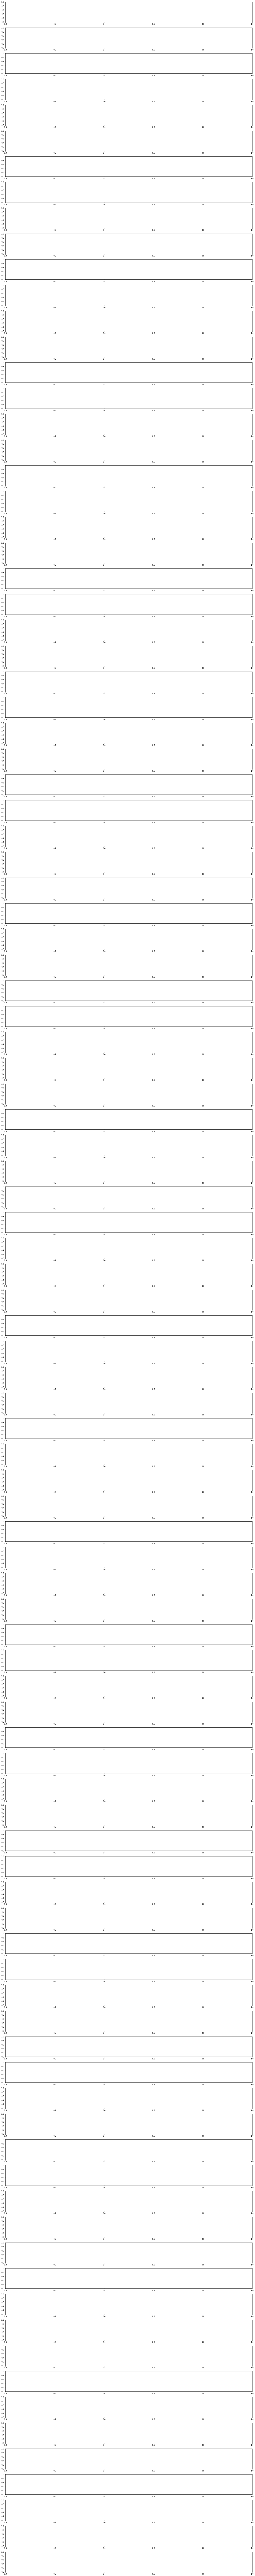

In [301]:
print(overlap_at_each_iterations.shape)
print(overlap_at_each_iterations.mean(1).shape)

# GRAPH STABILISATION DES OVERLAPS
fig, axs = plt.subplots(len(list_value_1)*len(list_value_2), figsize=(20,200), facecolor='white')
fig.tight_layout()

axs.grid()
axs.set_ylabel("overlap")
#for run_in_on_sample in range(size_of_one_sample):
axs.plot(overlap_at_each_iterations.mean(1)[0])

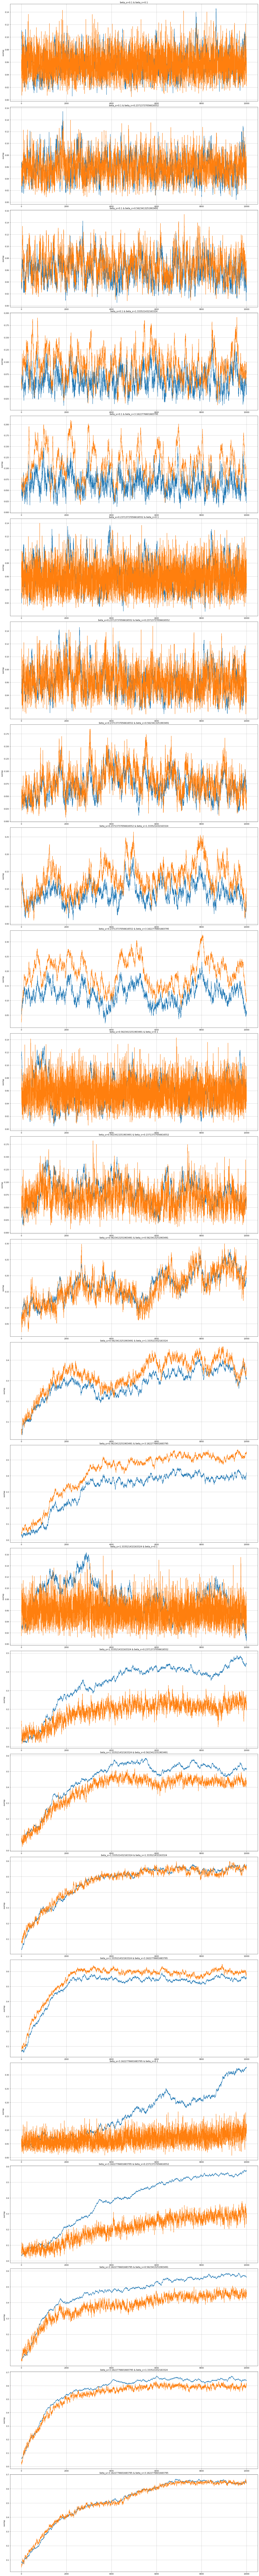

In [31]:
# GRAPH STABILISATION DES OVERLAPS
fig, axs = plt.subplots(len(list_value_1)*len(list_value_2), figsize=(20,200), facecolor='white')
fig.tight_layout()

for i in range(len(list_value_1)*len(list_value_2)):
    axs[i].grid()
    axs[i].set_ylabel("overlap")
    axs[i].set_title(f"{name_value_1}={list_value_1[i//len(list_value_2)]}"
                    + f" & {name_value_2}={list_value_2[i%len(list_value_2)]}")
    #for run_in_on_sample in range(size_of_one_sample):
    axs[i].plot(overlap_at_each_iterations.mean(1)[i])

In [ ]:
# GRAPH STABILISATION DES MEAN SQUARRE ERRORS
fig, axs = plt.subplots(len(list_value_1)*len(list_value_2), figsize=(20,200), facecolor='white')
fig.tight_layout()

for i in range(len(list_value_1)*len(list_value_2)):
    axs[i].grid()
    axs[i].set_ylabel("mse")
    axs[i].set_title(f"{name_value_1}={list_value_1[i//len(list_value_2)]}"
                    + f" & {name_value_2}={list_value_2[i%len(list_value_2)]}")
    for run_in_on_sample in range(size_of_one_sample):
        axs[i].plot(mse_at_each_iterations[i][run_in_on_sample])

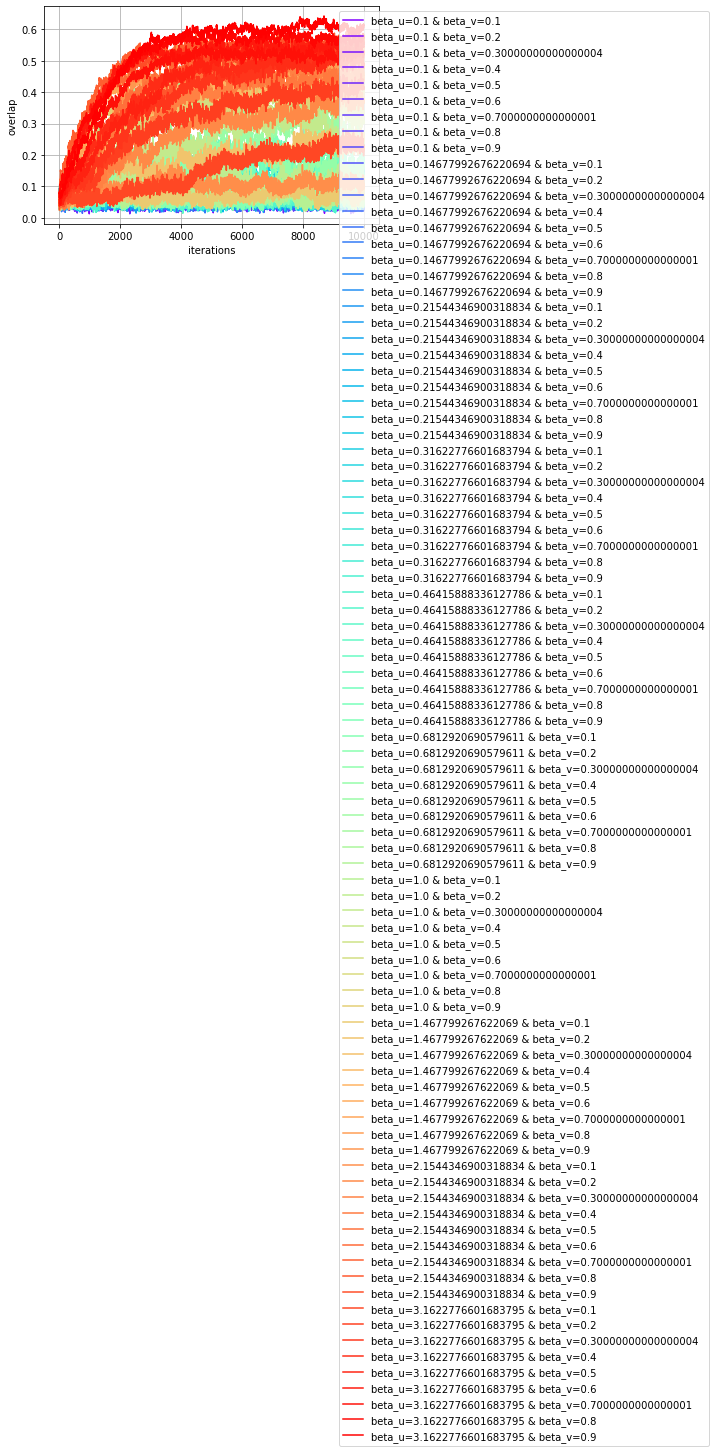

In [102]:
# PRINT THE OVERLAP IN FUNCTION OF THE STEP

# On calcul la moyenne des overlaps à chaque itérations dans un même sample avec:
# overlap_at_each_iterations.mean(axis=1)
#
# ~ moyenne_sample_1 = run_1_s1 + run_2_s2 + ... / size_of_one_sample
# ~ moyenne_sample_2 = run_1_s2 + run_2_s2 + ... / size_of_one_sample
# ...

# On calcul la moyenne des overlaps u et v à chaque itérations pour chaque sample avec:
# overlap_at_each_iterations.mean(axis=1)
#
# ~ moyenne_sample_1_uv = (moyenne_sample_1_u + moyenne_sample_1_v)/2
# ...

overlap_at_each_iterations_per_sample=overlap_at_each_iterations.mean(axis=1).mean(axis=2)

plt.figure(facecolor='white')
plt.grid()
plt.ylabel("overlap")
plt.xlabel("iterations")
color=iter(cm.rainbow(np.linspace(0,1,len(list_value_1)*len(list_value_2))))

for i in range(len(list_value_1)*len(list_value_2)):
    c=next(color)
    plt.plot(overlap_at_each_iterations_per_sample[i], 
             label=f"{name_value_1}={list_value_1[i//len(list_value_2)]}"
            + f" & {name_value_2}={list_value_2[i%len(list_value_2)]}", color=c)
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

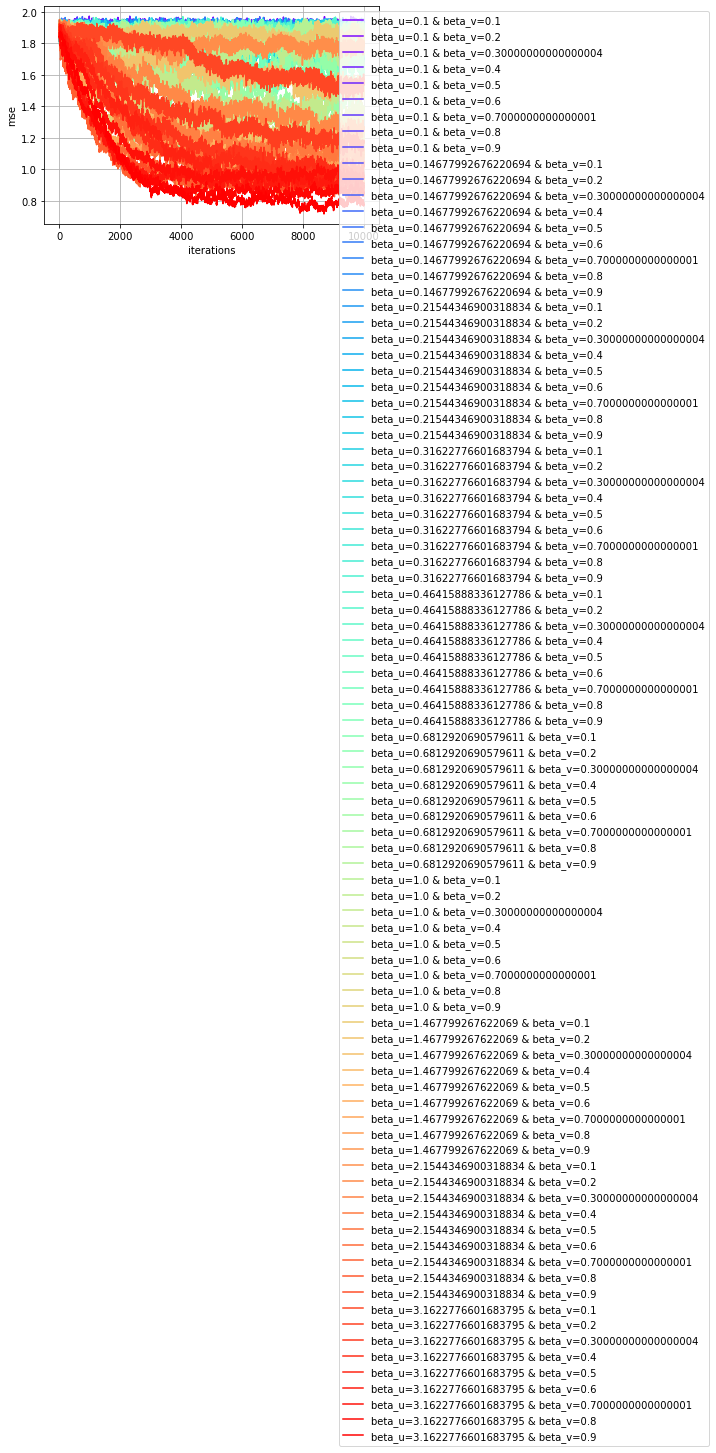

In [103]:
# PRINT THE MSE IN FUNCTION OF THE STEP
# same as the cell above but with the men squarre error:

mse_at_each_iterations_per_sample=mse_at_each_iterations.mean(axis=1).mean(axis=2)

plt.figure(facecolor='white')
plt.grid()
plt.ylabel("mse")
plt.xlabel("iterations")
color=iter(cm.rainbow(np.linspace(0,1,len(list_value_1)*len(list_value_2))))

for i in range(len(list_value_1)*len(list_value_2)):
    c=next(color)
    plt.plot(mse_at_each_iterations_per_sample[i], 
             label=f"{name_value_1}={list_value_1[i//len(list_value_2)]}"
            + f" & {name_value_2}={list_value_2[i%len(list_value_2)]}", color=c)
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

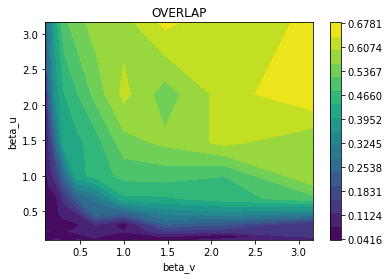

In [303]:
x, y = np.meshgrid(list_value_2,list_value_1)
overlap_mean=overlap_at_final_iteration.mean(axis=1).mean(axis=1)
overlap_mean=overlap_mean.reshape(len(list_value_1),len(list_value_2))

fig,ax=plt.subplots(1,1, facecolor='white')
plt.contourf(x,y,overlap_mean, 20)

ax.set_title("OVERLAP")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

# specify levels from vmim to vmax
levels = np.linspace(overlap_mean.min(), overlap_mean.max(), 10)
plt.colorbar(ticks=levels)
plt.show()

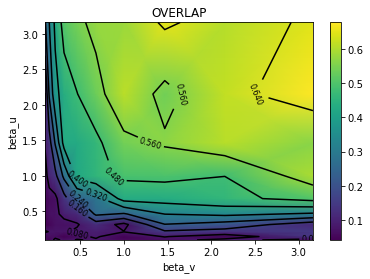

In [304]:
fig,ax=plt.subplots(1,1, facecolor='white')

ax.set_title("OVERLAP")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

# contour noir sur le graph
cnt = ax.contour(x,y,overlap_mean, origin='lower', colors='black')
ax.clabel(cnt, fontsize=8)

# graph avec shading
pcm=ax.pcolormesh(x, y, overlap_mean, shading="gouraud")

fig.colorbar(pcm)

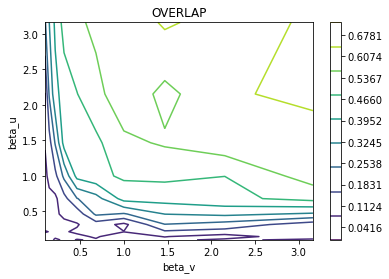

In [305]:
fig,ax=plt.subplots(1,1, facecolor='white')
plt.contour(x,y,overlap_mean)

ax.set_title("OVERLAP")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

# specify levels from vmim to vmax
levels = np.linspace(overlap_mean.min(), overlap_mean.max(), 10)
plt.colorbar(ticks=levels)
plt.show()

In [306]:
# with: [0.20049438 0.41059345 0.49443045 0.3862359  0.52844316 0.56942856]

# xx= [[0.5 1.  2. ]
#      [0.5 1.  2. ]]

# yy= [[0.5 0.5 0.5]
#      [1.  1.  1. ]]

# res= [[0.20049438 0.41059345 0.49443045]
#       [0.3862359  0.52844316 0.56942856]]

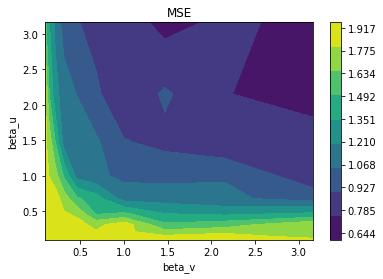

In [311]:
mse_mean=mse_at_final_iteration.mean(axis=1).mean(axis=1)

x, y = np.meshgrid(list_value_2,list_value_1)

mse_mean=mse_mean.reshape(len(list_value_1),len(list_value_2))

fig,ax=plt.subplots(1,1, facecolor='white')
plt.contourf(x,y,mse_mean, 10)

ax.set_title("MSE")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

# specify levels from vmim to vmax
levels = np.linspace(mse_mean.min(), mse_mean.max(), 10)
plt.colorbar(ticks=levels)
plt.show()

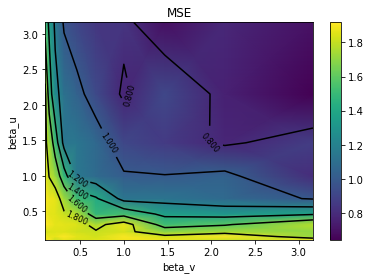

In [308]:
fig,ax=plt.subplots(1,1, facecolor='white')

ax.set_title("MSE")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

# contour noir sur le graph
cnt = ax.contour(x,y,mse_mean, origin='lower', colors='black')
ax.clabel(cnt, fontsize=8)

# graph avec shading
pcm=ax.pcolormesh(x, y, mse_mean, shading="gouraud")

fig.colorbar(pcm)

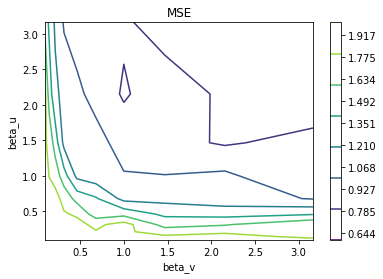

In [309]:
fig,ax=plt.subplots(1,1, facecolor='white')

ax.set_title("MSE")
ax.set_xlabel(f"{name_value_2}")
ax.set_ylabel(f"{name_value_1}")

plt.contour(x,y,mse_mean)

# specify levels from vmim to vmax
levels = np.linspace(mse_mean.min(), mse_mean.max(), 10)
plt.colorbar(ticks=levels)
plt.show()